In [1]:
import os
import dlib
import cv2
from PIL import Image
import pandas as pd
from tqdm import tqdm
import numpy as np
def to_pil(cv_img):
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

path = '/home/allen/elder.jpg'
detector = dlib.get_frontal_face_detector()
p = "/home/allen/Downloads/shape_predictor_5_face_landmarks.dat"
aligner = dlib.shape_predictor(p)

In [2]:
img = cv2.imread(path) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dets = detector(img, 0)
faces = []
for i in range(len(dets)):
    tl = dets[i].tl_corner()
    br = dets[i].br_corner()
    x1, y1 = tl.x, tl.y
    x2, y2 = br.x, br.y
    faces.append([x1, y1, x2 - x1, y2 - y1])

In [3]:
landmark = aligner(img, dets[0])

landmarks = []
for i in [0,2,4]:
    if i == 0 or i == 2:
        x1 = landmark.part(i).x
        y1 = landmark.part(i).y
        x2 = landmark.part(i+1).x
        y2 = landmark.part(i+1).y
        landmarks.append([(x1+x2)//2,(y1+y2)//2])
    else:
        x1 = landmark.part(i).x
        y1 = landmark.part(i).y
        landmarks.append([x1, y1])

In [4]:
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)   
for i, (x, y) in enumerate(landmarks):
    cv2.circle(img, (int(x), int(y)), 3, (255,255,255), 3)
#     cv2.putText(img, str(i), (int(x), int(y)), cv2.FONT_HERSHEY_DUPLEX, 2, (255,255,255), 2)

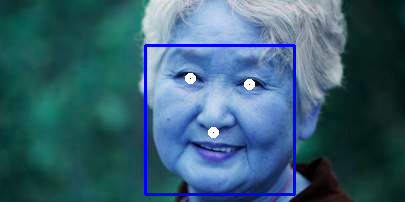

In [5]:
to_pil(img)

In [6]:
outputFaceWidth = outputFaceHeight = 224
leftEyeToLeftEdgeProportion = 0.35
rightEyeToRightEdgeProportion = 1 - leftEyeToLeftEdgeProportion

leftEye = np.array(landmarks[1])
rightEye = np.array(landmarks[0])
dY = rightEye[1] - leftEye[1]
dX = rightEye[0] - leftEye[0]
angle = np.degrees(np.arctan2(dY, dX))
currentBetweenEyesLength = np.sqrt((dX ** 2) + (dY ** 2))
betweenEyesProportion = (rightEyeToRightEdgeProportion - leftEyeToLeftEdgeProportion)
betweenEyesLength = betweenEyesProportion * outputFaceWidth
scale = betweenEyesLength / currentBetweenEyesLength

eyesCenter = (leftEye + rightEye) / 2
eyesCenter.astype(np.int)
M = cv2.getRotationMatrix2D(tuple(eyesCenter), angle, scale)
tX = outputFaceWidth * 0.5
tY = outputFaceHeight * leftEyeToLeftEdgeProportion
M[0, 2] += (tX - eyesCenter[0])
M[1, 2] += (tY - eyesCenter[1])
(w, h) = (outputFaceWidth, outputFaceHeight)
alignedImg = cv2.warpAffine(img, M, (w, h),
    flags=cv2.INTER_CUBIC) 

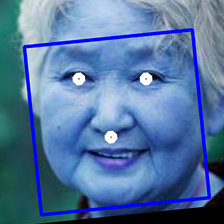

In [7]:
to_pil(alignedImg)

In [11]:
import os.path as osp

In [24]:
path = "/media/allen/mass/DB/emotion/emotion_test_112_112/"
img_paths = [(osp.join(root, f)) for root, _, files in os.walk(path) for f in files if '.png' in f or '.jpg' in f]

In [25]:
outputFaceWidth = outputFaceHeight = 112
leftEyeToLeftEdgeProportion = 0.35
rightEyeToRightEdgeProportion = 1 - leftEyeToLeftEdgeProportion
DSTFOLDER = "/media/allen/mass/DB/emotion/emotion_test_aligned"

for imgpath in tqdm(img_paths, desc="Align"):
    emotion, filename = imgpath.split("/")[-2:]
    imgdst = os.path.join(DSTFOLDER, emotion)
    if not os.path.exists(imgdst):
        os.mkdir(imgdst)

    img = cv2.imread(imgpath) 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    for face in faces:
        landmark = aligner(gray, face)
        landmarks = []
        for i in [0,2,4]:
            if i == 0 or i == 2:
                x1 = landmark.part(i).x
                y1 = landmark.part(i).y
                x2 = landmark.part(i+1).x
                y2 = landmark.part(i+1).y
                landmarks.append([(x1+x2)//2,(y1+y2)//2])
            else:
                x1 = landmark.part(i).x
                y1 = landmark.part(i).y
                landmarks.append([x1, y1])
        
        leftEye = np.array(landmarks[1])
        rightEye = np.array(landmarks[0])
        dY = rightEye[1] - leftEye[1]
        dX = rightEye[0] - leftEye[0]
        angle = np.degrees(np.arctan2(dY, dX))
        currentBetweenEyesLength = np.sqrt((dX ** 2) + (dY ** 2))
        betweenEyesProportion = (rightEyeToRightEdgeProportion - leftEyeToLeftEdgeProportion)
        betweenEyesLength = betweenEyesProportion * outputFaceWidth
        scale = betweenEyesLength / currentBetweenEyesLength

        eyesCenter = (leftEye + rightEye) / 2
        eyesCenter.astype(np.int)
        M = cv2.getRotationMatrix2D(tuple(eyesCenter), angle, scale)
        tX = outputFaceWidth * 0.5
        tY = outputFaceHeight * leftEyeToLeftEdgeProportion
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])
        (w, h) = (outputFaceWidth, outputFaceHeight)
        alignedImg = cv2.warpAffine(img, M, (w, h),
            flags=cv2.INTER_CUBIC) 

        cv2.imwrite(os.path.join(imgdst, filename), alignedImg)
    
#     break

Align: 100%|██████████| 980/980 [00:12<00:00, 76.83it/s]


In [20]:
landmarks

In [9]:
img_paths[0]

IndexError: list index out of range